# ПРИОРИТИЗАЦИЯ ГИПОТЕЗ | A/B ТЕСТИРОВАНИЕ

<a name="Содержание"></a> 
## Содержание:
0. [Описание проекта, описание данных, загрузка и импорт библиотек](#0.)
1. [Приоритизация гипотез. Расчет ICE / RICE score](#1.)
2. [Предобработка данных](#2.)   
    2.1. [Датасет orders](#2.1.)  
    2.2. [Датасет visitors](#2.2.)
3. [Анализ A/B-теста](#3.)  
    3.1. [Кумулятивная выручка по группам](#3.1.)  
    3.2. [Кумулятивный средний чек по группам](#3.2.)  
    3.3. [Относительное изменение кумулятивного среднего чека группы B к группе A](#3.3.)  
    3.4. [Кумулятивная конверсия по группам](#3.4.)  
    3.5. [Относительное изменение кумулятивной конверсии группы B к группе A](#3.5.)  
    3.6. [Точечный график количества заказов по пользователям](#3.6.)  
    3.7. [Точечный график стоимостей заказов](#3.7.)  
4. [Проверка статистической значимости различий в группах A/B теста](#4.)  
    4.1. [Статистическая значимость различий в конверсии между группами по «сырым» данным](#4.1.)  
    4.2. [Статистическая значимость различий среднего чека заказа между группами по «сырым» данным](#4.2.)  
    4.3. [Статистическая значимость различий в конверсии между группами по «очищенным» данным](#4.3.)  
    4.4. [Статистическая значимость различий среднего чека заказа между группами по «очищенным» данным](#4.4.)  
5. [Выводы](#5.)  

<a name="0."></a>
## 0. Описание проекта [↑](#Содержание)

Клиент - крупный онлайн-ритейлер. Отдел маркетинга подготовил список гипотез для увеличения выручки, необходимо приоритизировать их и проанализировать результаты проведенного A/B-теста. Прежде всего нужно рассмотреть изменения в среднем чеке, конверсии и количестве заказов.

#### Описание данных [↑](#Содержание)

Датасет **`hypothesis.csv`** cсодержат список гипотез.  
`hypothesis` — краткое описание гипотезы;  
`reach` — охват пользователей по 10-балльной шкале;  
`impact` — влияние на пользователей по 10-балльной шкале;  
`confidence` — уверенность в гипотезе по 10-балльной шкале;  
`efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  
  

Датасет **`orders.csv`**, 1197 записей. Содержит информацию о заказах пользователей в период с 01-08-2019 по 31-08-2019.  
`transactionId` — идентификатор заказа;  
`visitorId` — идентификатор пользователя, совершившего заказ;  
`date` — дата, когда был совершён заказ;  
`revenue` — выручка заказа;  
`group` — группа A/B-теста, в которую попал заказ.  
  
Датасет **`visitors.csv`**, 62 записи.  Содержит информацию о визитах пользователей в период с 01-08-2019 по 31-08-2019.  
`date` — дата;  
`group` — группа A/B-теста;  
`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.  

#### Импорт библиотек, настройки Jupiter [↑](#Содержание)

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime as dt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [170]:
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_columns', None)

<a name="1."></a>
### 1. Приоритизация гипотез. Расчет ICE / RICE score [↑](#Содержание)

In [171]:
path = 'C:/Users/Sergey/Desktop/'
hypothesis = pd.read_csv(path + 'hypothesis.csv')

In [172]:
hypothesis.head(3)

,Unnamed: 0,hypothesis,reach,impact,confidence,efforts
0,0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3


In [173]:
# ICE score
hypothesis['ICEscore'] = ((hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']).round(1)
# RICE score
hypothesis['RICEscore'] = ((hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']).round(1)

In [174]:
hypothesis[['reach', 'ICEscore', 'RICEscore']].sort_values(by='ICEscore', ascending=False)

,reach,ICEscore,RICEscore
8,1,16.2,16.2
0,3,13.3,40.0
7,10,11.2,112.0
6,5,8.0,40.0
2,8,7.0,56.0
1,2,2.0,4.0
5,3,1.3,4.0
3,8,1.1,9.0
4,3,1.0,3.0


**Выводы:**  
при применении RICE score вместо ICE некоторые гипотезы стали значительнее приоритетнее (например, гипотезы 7, 2). У данных гипотез показатель reach больше среднего - 10 и 8, соответственно. В целом, наблюдается картина, при котороый высокий уровень охвата (reach) может выводить гипотезы на более приоритетные позиции, по сравнению с ICE приоритизацией. При этом низкий уровень reach (гипотеза 8) может значительно снижать позицию гипотезы в рамках RICE приоритизации.

----

<a name="2."></a>
### 2. Предобработка данных [↑](#Содержание)

<a name="2.1."></a>
#### 2.1. Датасет orders [↑](#Содержание)

In [175]:
orders = pd.read_csv(path + 'orders.csv', index_col=0)
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [176]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 56.1+ KB


В датасете отсутствуют полные дубликаты и пропуски. Колонку date следует привести к типа `datetime`. Переименуем названия колонок для удобства.

In [177]:
#  Переименуем названия столбцов для удобства. Изменим тип данных колонки date
orders.columns = ['orderid', 'id', 'date', 'revenue', 'group']
orders['date'] = orders['date'].astype('datetime64')

Проверим на равные ли части поделён трафик между группами A/B теста.

In [178]:
print("Вcего уникальных ID: {}".format(orders['id'].nunique()))
orders.pivot_table(index='group', aggfunc={'id':'nunique'})

Вcего уникальных ID: 1031


,id
group,
A,503
B,586


Всего в orders 1031 уникальных id, но при группировке по A/B группам их 1089 (больше примерно на 5%). По всей видимости, некоторые id в какой-то момент попали в обе группы. Найдем данные id и удалим из датасета, чтобы не искажать результаты теста.

In [179]:
#  формируем список id у которых есть покупки в A и B группах одновременно
id_not_valide = orders.groupby('id', as_index=False).agg({'group':'nunique'})
id_not_valide = id_not_valide[id_not_valide['group'] >= 2][['id']]
print("Количество ID, попавших в обе группы: {}".format(id_not_valide.count()[0]))

Количество ID, попавших в обе группы: 58


Чтобы сократить искажение в таблице `visits`, в которой находятся все пользователи, в том числе и те, которые пребывали и в A и в B группах -мы создадим таблицу с количеством этих пользователей, приходящихся на каждый день. Позднее их удалим в таблице `visitors`.

In [180]:
# Создаем таблицу с id, которые находились в обеих группах теста
orders_wrong = orders[np.logical_not(~orders['id'].isin(id_not_valide['id']))]
orders_wrong['id'].nunique()

58

In [181]:
# находим количество пользователей, находящихся в обеих группах теста на каждый день теста
id_orders_wrong = orders_wrong.groupby(['date', 'group'], as_index=False).agg({'id':'nunique'})
id_orders_wrong.head(3)

,date,group,id
0,2019-08-01,A,1
1,2019-08-01,B,3
2,2019-08-02,A,1


In [182]:
#  исключаем найденные id из общего датасета orders
orders = orders[np.logical_not(orders['id'].isin(id_not_valide['id']))]

#  проверяем в датасете количество id, находящихся в 2 группах одновременно
id_not_valide = orders.groupby('id', as_index=False).agg({'group':'nunique'})
id_not_valide = id_not_valide[id_not_valide['group'] >= 2][['id']]
id_not_valide.count()

id    0
dtype: int64

In [183]:
orders.pivot_table(index='group', aggfunc={'id':'nunique'})

,id
group,
A,445
B,528


Видим, что в датасете различное количество заказов в группах. В группе B наблюдается большее количество сделанных заказов.

<a name="2.2."></a>
#### 2.2. Датасет visitors [↑](#Содержание)

In [184]:
visitors = pd.read_csv(path + 'visitors.csv', index_col=0)
visitors.head(3)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507


In [185]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.9+ KB


В таблице наблюдается некорректный тип данных колонки `date`.

In [186]:
visitors['date'] = visitors['date'].astype('datetime64')

In [187]:
# мерджим visitors с таблицей id_orders_wrong, ID которых пребывали в обоих группах теста одновременно
visitors = visitors.merge(id_orders_wrong, how='left', on=['date','group'])

# переименовываем столбец с данными ID
visitors.rename({'id':'wrong_id'}, axis=1, inplace=True)
visitors.head(3)

,date,group,visitors,wrong_id
0,2019-08-01,A,719,1.0
1,2019-08-02,A,619,1.0
2,2019-08-03,A,507,NaN


In [188]:
# заполняем NaN в колонке wrong_id
visitors['wrong_id'].fillna(0, inplace=True)
# считаем количество пользователей без пользователей, находившихся в 2 группах одновременно
visitors['visitors'] = (visitors['visitors'] - visitors['wrong_id']).astype('int')
# удаляем столбец с данными пользователями
visitors = visitors.drop(['wrong_id'], axis=1)
visitors.head(3)

,date,group,visitors
0,2019-08-01,A,718
1,2019-08-02,A,618
2,2019-08-03,A,507


<a name="3."></a>
### 3. Анализ A/B-теста [↑](#Содержание)

<a name="3.1."></a>
#### 3.1. Кумулятивная выручка по группам [↑](#Содержание)

In [189]:
# создаем пары значений дат и групп теста
date_group = orders[['date','group']].drop_duplicates()
date_group.head(2)

,date,group
0,2019-08-15,B
7,2019-08-15,A


In [190]:
# агреггируем кумулятивные данные о заказах 
orders_agg = date_group.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
                              .agg({'date' : 'max', 'group' : 'max', 'orderid' : pd.Series.nunique,\
                              'id' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
orders_agg.head(3)

,date,group,orderid,id,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381


In [191]:
# агреггируем кумулятивные данные о визитах
visitors_agg = date_group.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                  visitors['group'] == x['group'])]\
                              .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)\
                              .sort_values(by=['date','group'])
visitors_agg.head(3)

,date,group,visitors
55,2019-08-01,A,718
66,2019-08-01,B,710
175,2019-08-02,A,1336


In [192]:
#  джойним данные обеих таблиц
data = orders_agg.merge(visitors_agg, on=['date', 'group'])
data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
data.head(3)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,718
1,2019-08-01,B,17,17,59758,710
2,2019-08-02,A,42,36,234381,1336


In [193]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cummulative_revenue_A = data[data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cummulative_revenue_B = data[data['group']=='B'][['date','revenue', 'orders']]

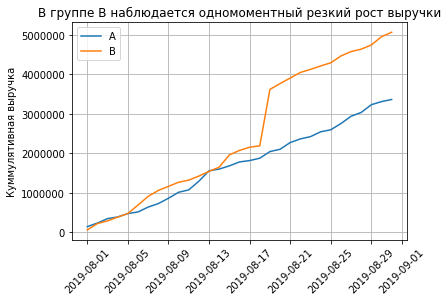

In [194]:
# строим график
fig, ax = plt.subplots()
plt.plot(cummulative_revenue_A['date'], cummulative_revenue_A['revenue'], label='A')
plt.plot(cummulative_revenue_B['date'], cummulative_revenue_B['revenue'], label='B')
ax.set(ylabel='Куммулятивная выручка',
       title='В группе B наблюдается одномоментный резкий рост выручки')
plt.tick_params(axis='x', rotation=45)
plt.grid()
plt.legend()

**Результаты.**  
  
В начале периода группы вели себя похоже, затем в группе B мы можем наблюдать повышение кумулятивной выручки в сравнение с группой А, но затем группы вновь сравниваются. В середине периода наблюдаем резкий значительный скачок кумулятивной выручки в группе B. Вероятно, такой резкий скачок связан с несколькими аномальными покупками или с аномальным количеством покупок у одного или нескольких покупателей.

<a name="3.2."></a>
#### 3.2. Кумулятивный средний чек по группам [↑](#Содержание)

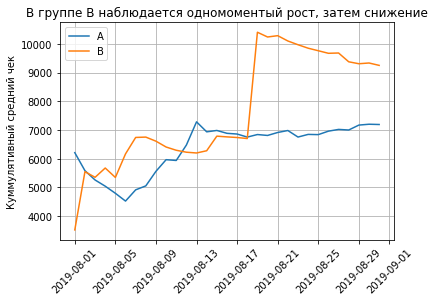

In [195]:
fig, ax = plt.subplots()
plt.plot(cummulative_revenue_A['date'], (cummulative_revenue_A['revenue']/cummulative_revenue_A['orders']), label='A')
plt.plot(cummulative_revenue_B['date'], (cummulative_revenue_B['revenue']/cummulative_revenue_B['orders']), label='B')
plt.tick_params(axis='x', rotation=45)
ax.set(ylabel='Куммулятивный средний чек',
       title='В группе B наблюдается одномоментый рост, затем снижение')
plt.grid()
plt.legend()

**Результаты**  

По графикам сложно определить какую-то определенную тенденцию - в обоих группах наблюдаются повышения и понижения среднего чека. В группе B (как и в графике по выручке) видим резкий скачок - значит он связан с одной или несколькими аномально высокими по стоимости покупками.

<a name="3.3."></a>
#### 3.3. Относительное изменение кумулятивного среднего чека группы B к группе A [↑](#Содержание)

In [196]:
# собираем данные в одном датафрейме
сummulative_revenue = cummulative_revenue_A.merge\
                                      (cummulative_revenue_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
сummulative_revenue.head(3)

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54


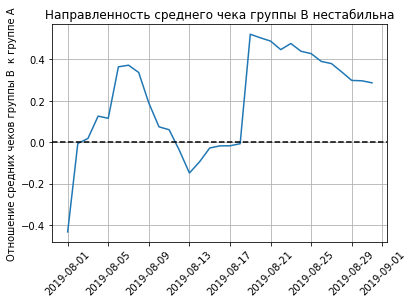

In [197]:
# cтроим отношение средних чеков
fig, ax = plt.subplots()
plt.plot(сummulative_revenue['date'],\
                                     (сummulative_revenue['revenueB']/сummulative_revenue['ordersB'])/\
                                     (сummulative_revenue['revenueA']/сummulative_revenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.tick_params(axis='x', rotation=45)
ax.set(ylabel='Отношение средних чеков группы B  к группе A',
       title='Направленность среднего чека группы B нестабильна')
plt.grid()

**Результаты.**

По графику нельзя однозначно определить стабильно выше ли средний чек группы B. В графике видны как повышения, так и снижения среднего чека в группе B. Возможно, если удалить выбросы - картина станет более ясной.

<a name="3.4."></a>
#### 3.4. Кумулятивная конверсия по группам [↑](#Содержание)

In [198]:
# считаем кумулятивную конверсию
data['conversion'] = data['orders']/data['visitors']

# отделяем данные по группе A и B
data_A = data[data['group']=='A']
data_B = data[data['group']=='B']

['2019-08-01', '2019-08-31', 0.02, 0.04]

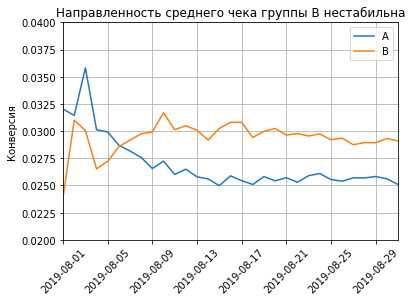

In [199]:
# строим график
fig, ax = plt.subplots()
plt.plot(data_A['date'], data_A['conversion'], label='A')
plt.plot(data_B['date'], data_B['conversion'], label='B')

plt.axhline(y=0, color='black', linestyle='--')
plt.tick_params(axis='x', rotation=45)
ax.set(ylabel='Конверсия',
       title='Направленность среднего чека группы B нестабильна')
plt.grid()
plt.legend()
plt.axis(["2019-08-01", '2019-08-31', 0.020, 0.040])

**Результаты.**  
  
В начале периода обе групппы показывали рост конверсии, затем в группе А конверсия значительно снизилась, при том, что в группе B выросла. В группе B до конца периода конверсия остается более высокой по сравнению с А группой. Однако, судя по графику конверсия B со временем всё-таки тяготеет к снижению.

<a name="3.5."></a>
#### 3.5. Относительное изменение кумулятивной конверсии группы B к группе A  [↑](#Содержание)

In [200]:
#  собираем данные в одном датафрейме
cummulative_conversion = data_A.merge(data_B, on='date', suffixes=['A', 'B'])
cummulative_conversion.head(3)

,date,groupA,ordersA,buyersA,revenueA,visitorsA,conversionA,groupB,ordersB,buyersB,revenueB,visitorsB,conversionB
0,2019-08-01,A,23,19,142779,718,0.032033,B,17,17,59758,710,0.023944
1,2019-08-02,A,42,36,234381,1336,0.031437,B,40,39,221801,1290,0.031008
2,2019-08-03,A,66,60,346854,1843,0.035811,B,54,53,288850,1797,0.030050


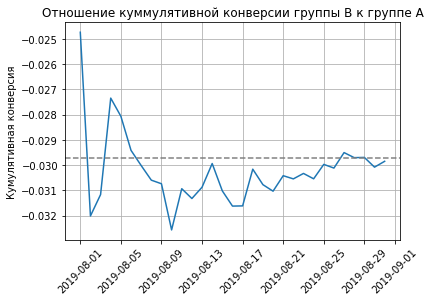

In [201]:
#  строим график
fig, ax = plt.subplots()
plt.plot(cummulative_conversion['date'], cummulative_conversion['conversionB']/(cummulative_conversion['conversionA']-1))

plt.axhline(y=-0.0297, color='grey', linestyle='--')
plt.tick_params(axis='x', rotation=45)
ax.set(ylabel='Кумулятивная конверсия',
       title='Отношение куммулятивной конверсии группы B к группе A')
plt.grid()

**Результаты.**  
  
Кумулятивная конверсия группы B начале периода резко снижается, затем следуют как понижения, так и повышения. В концу периода наблюдается постепенное повышение.

<a name="3.6."></a>
#### 3.6. Точечный график количества заказов по пользователям [↑](#Содержание)

In [202]:
#  аггрегируем данные по количеству заказов на пользователя
orders_count = orders.groupby('id', as_index=False).agg({'orderid':'count'})
orders_count.head(3)

,id,orderid
0,5114589,1
1,6958315,1
2,11685486,1


[Text(0, 0.5, 'Заказов на 1 пользователя'),
 Text(0.5, 1.0, 'Наименьшая доля  пользователей делает более 2 заказов')]

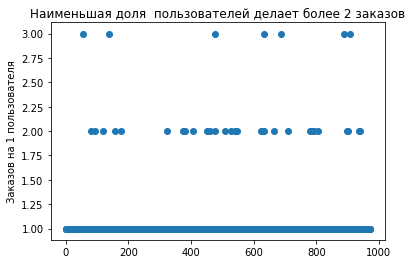

In [203]:
# строим точечный график количества заказов на пользователя
x_values = pd.Series(range(0,len(orders_count['orderid'])))

fig, ax = plt.subplots()
plt.scatter(x_values, orders_count['orderid'])
ax.set(ylabel='Заказов на 1 пользователя',
       title='Наименьшая доля  пользователей делает более 2 заказов')

In [204]:
num = orders_count.groupby('orderid').count()\
                               .reset_index()
num = num.rename({'orderid':'orders_per_ID', 'id':'count_ID'}, axis=1)
num                    

,orders_per_ID,count_ID
0,1,937
1,2,29
2,3,7


**Результаты**

Подавляющее число пользователей делало заказ всего один раз. Около 3-5% делало повторный заказ. Менее 1% заказывало 3 раза.

In [205]:
np.percentile(orders_count['orderid'], [95, 99])

array([1., 2.])

Не более 1% пользователей делают более 2 заказов. Будем считать аномальными пользователей с более, чем 2 заказами.

<a name="3.7."></a>
#### 3.7. Точечный график стоимостей заказов [↑](#Содержание)


[Text(0, 0.5, 'Стоимость заказа'),
 Text(0.5, 1.0, 'Основная часть заказов не выходит за рамки стоимости 200 000')]

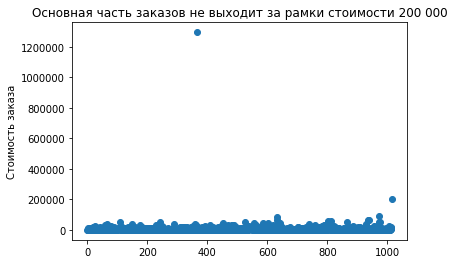

In [206]:
# строим точечный график стоимости заказа
x_values = pd.Series(range(0,len(orders['revenue'])))

fig, ax = plt.subplots()
plt.scatter(x_values, orders['revenue'])
ax.set(ylabel='Стоимость заказа',
       title='Основная часть заказов не выходит за рамки стоимости 200 000')

[Text(0, 0.5, 'Стоимость заказа'),
 Text(0.5, 1.0, 'Основная часть заказов приходится до 50 000')]

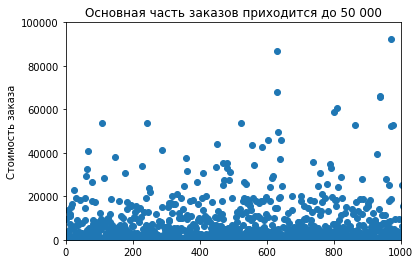

In [207]:
# строим точечный график стоимости заказа в более крупном масштабе (исключив 2 аномальные точки)
fig, ax = plt.subplots()
plt.scatter(x_values, orders['revenue'])
plt.axis([0, 1000, 0, 100000])
ax.set(ylabel='Стоимость заказа',
       title='Основная часть заказов приходится до 50 000')

In [208]:
np.percentile(orders['revenue'], [97, 99])

array([34792., 53904.])

На первом графике видно 2 аномальных заказах, при изменении масштаба видно, что их больше - не более 1% пользователей делают заказ свыше 53904. Аномальным будем считать заказы дороже 99 перцентиля.

<a name="4."></a>
### 4. Проверка статистической значимости различий в группах A/B теста [↑](#Содержание)

<a name="4.1."></a>
#### 4.1. Статистическая значимость различий в конверсии между группами по «сырым» данным [↑](#Содержание)

In [209]:
#  создаем срезы количества заказов по датам и группам теста
ordersA_count = orders[orders['group']=='A'].groupby('date', as_index=False).agg({'orderid': 'count'})
ordersA_count.columns = ['date', 'buyers']

ordersB_count = orders[orders['group']=='B'].groupby('date', as_index=False).agg({'orderid': 'count'})
ordersB_count.columns = ['date', 'buyers']

#  создаем срезы количества покупателей по датам и группам теста
visitorsA = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsB = visitors[visitors['group']=='B'][['date', 'visitors']]

#  переименовываем столбцы в изначальной таблице кумулятивных данных
cummulative_data = cummulative_conversion[['date', 'ordersA', 'ordersB', 'buyersA', 'buyersB', 'visitorsA', 'visitorsB', 'revenueA', 'revenueB']]
cummulative_data.columns = ['date', 'cummulative_ordersA', 'cummulative_ordersB', 'cummulative_buyersA', 'cummulative_buyersB', 'cummulative_visitorsA', 'cummulative_visitorsB', 'cummulative_revenueA', 'cummulative_revenueB']

#  мерджим получившиеся таблицы с таблицей кумулятивных данных в одну
cummulative_data = cummulative_data.merge(ordersA_count, on='date', suffixes=['A', 'B']).\
                                    merge(ordersB_count, on='date', suffixes=['A', 'B']).\
                                    merge(visitorsA, on='date', suffixes=['A', 'B']).\
                                    merge(visitorsB, on='date', suffixes=['A', 'B'])
cummulative_data.head(2)

,date,cummulative_ordersA,cummulative_ordersB,cummulative_buyersA,cummulative_buyersB,cummulative_visitorsA,cummulative_visitorsB,cummulative_revenueA,cummulative_revenueB,buyersA,buyersB,visitorsA,visitorsB
0,2019-08-01,23,17,19,17,718,710,142779,59758,23,17,718,710
1,2019-08-02,42,40,36,39,1336,1290,234381,221801,19,23,618,580


In [210]:
# аггрегируем данные по количеству заказов для каждого покупателя
ordersA = orders[orders['group']=='A'].groupby('id', as_index=False).agg({'orderid' : pd.Series.nunique})
ordersA.columns = ['userid', 'orders']

ordersB = orders[orders['group']=='B'].groupby('id', as_index=False).agg({'orderid' : pd.Series.nunique})
ordersB.columns = ['userid', 'orders']

In [211]:
#  создаем таблицы, состоящие из двух частей: 1-ая часть таблиц  - соответствующие таблицы ordersA и ordersB, 
#     а вторая часть нулевые значения - пользователи, которые не сделали ни одной покупки
sampleA = pd.concat([ordersA['orders'],pd.Series\
                     (0, index=np.arange(cummulative_data['visitorsA'].sum() - len(ordersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersB['orders'],pd.Series\
                     (0, index=np.arange(cummulative_data['visitorsB'].sum() - len(ordersB['orders'])), name='orders')],axis=0)

In [212]:
# применяем статистический критерий Манна-Уитни к полученным выборкам
print("{0:.3f} P-value".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("{0:.3f} Отношение конверсии группы B к группе A".format(sampleB.mean()/sampleA.mean()-1))

0.006 P-value
0.160 Отношение конверсии группы B к группе A


**Результаты.**  
  
P-value меньше уровня 0.05 и соответственно, нам следует отвергнуть нулевую гипотезу о том, что нет статистически значимых различий в конверсии в исследуемых группах и принять альтернативную гипотезу, гласящую о том, что между исследуемыми группами могут иметь место статистически значимые различия в конверсии. В рассматриваемом периоде это различие составляет 16% в пользу группы B.

<a name="4.2."></a>
#### 4.2. Статистическая значимость различий среднего чека заказа между группами по «сырым» данным [↑](#Содержание)

In [213]:
# применяем статистический критерий Манна-Уитни к выборкам
print("{0:.3f} P-value".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print("{0:.3f} Отношение среднего чека группы B к группе A".format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.415 P-value
0.287 Отношение среднего чека группы B к группе A


**Результаты.** 
  
P-value значительно выше уровня 0.05 и соответственно, мы не можем отвергать нулевую гипотезу о том, что нет статистически значимых различий в размере среднего чека в исследуемых группах. Однако, интересно увидеть, что в группе B относительный прирост среднего чека составляет 28,7%. Вероятно, что это это связано с несколькими аномальными заказами.

<a name="4.3."></a>
#### 4.3. Статистическая значимость различий в конверсии между группами по «очищенным» данным [↑](#Содержание)

Составим список пользователей с "аномальным" поведением.

In [214]:
#  создаем список аномальных userid, у которых более 1 заказа за период
usersWithManyOrders = pd.concat([ordersA[ordersA['orders'] > np.percentile(orders_count['orderid'], [99])[0]]['userid'],\
                                 ordersB[ordersB['orders'] > np.percentile(orders_count['orderid'], [99])[0]]['userid']], axis = 0)


#  создаем список аномальных userid, которые тратили более 27000 за заказ
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], [99])[0]]['id']

#  объединяем обе таблицы, удаляем дубликаты
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print("Всего 'аномальных' пользователей: {} ({:.1%})".format(abnormalUsers.count(), 
                                                             abnormalUsers.count() / orders['id'].nunique()))

Всего 'аномальных' пользователей: 16 (1.6%)


In [215]:
#  создаем таблицы, состоящие из двух частей: 1-ая часть таблиц  - соответствующие таблицы ordersA и ordersB, 
#     а вторая часть нулевые значения - пользователи, которые не сделали ни одной покупки
sampleAFiltered = pd.concat([ordersA[np.logical_not(ordersA['userid'].isin(abnormalUsers))]['orders'],\
                             pd.Series(0, index=np.arange(cummulative_data['visitorsA'].sum() - len(ordersA['orders'])),\
                                       name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersB[np.logical_not(ordersB['userid'].isin(abnormalUsers))]['orders'],\
                             pd.Series(0, index=np.arange(cummulative_data['visitorsB'].sum() - len(ordersB['orders'])),\
                                       name='orders')],axis=0)

In [216]:
# применяем статистический критерий Манна-Уитни к полученным выборкам
print("{0:.3f}  P-value".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f} Отношение конверсии группы B к группе A".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.004  P-value
0.189 Отношение конверсии группы B к группе A


**Результаты.**  
  
Как и в "сырых данных" P-value меньше уровня 0.05 и соответственно, нам следует отвергнуть нулевую гипотезу о том, что нет статистически значимых различий в конверсии в исследуемых группах и принять альтернативную гипотезу. Относительный прирост выше в "очищенных" данных 18,9% против 16% "сырых" данных в пользу группы B.

<a name="4.4."></a>
#### 4.4. Статистическая значимость различий среднего чека заказа между группами по «очищенным» данным [↑](#Содержание)

In [217]:
# применим статистический критерий Манна-Уитни к выборкам

print("{0:.3f} P-value".format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['id'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['id'].isin(abnormalUsers)))]['revenue'])[1]))

print("{0:.3f}  Отношение среднего чека группы B к группе A".format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['id'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['id'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.394 P-value
-0.032  Отношение среднего чека группы B к группе A


**Результаты.**  
  
P-value значительно выше уровня 0.05 и соответственно, мы не можем отвергать нулевую гипотезу о том, что нет статистически значимых различий в размере среднего чека в исследуемых группах, как и в случае с "сырыми данными".  
Как и предполагалось, высокий прирост среднего чека в "сырых" данных был связан с аномально дорогими заказами. Прирост среднего чека снизился с 28,7% в "сырых" данных до отрицательных -3.2% в очищенных.

<a name="5."></a>
#### 5. Выводы [↑](#Содержание)

Тестирование следует остановить и считать удачным. 
1. По результатам теста в группе B отмечается статистически значимый прирост конверсии на 16% (после очистки от "аномальных" пользователей - 18,9%).
2. Статистически значимого прироста в среднем чеке не отмечается.